### Annotate Images with labelme

In [1]:
!labelme

### Review Dataset and Build Image Loading Function

In [2]:
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU detected:", gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs detected")

No GPUs detected


In [4]:
images = tf.data.Dataset.list_files("data\images\*.jpg", shuffle=False)

In [5]:
images.as_numpy_iterator().next()

b'data\\images\\7e79af53-e2b5-11ed-8461-c89402821e26.jpg'

In [6]:
def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_images)

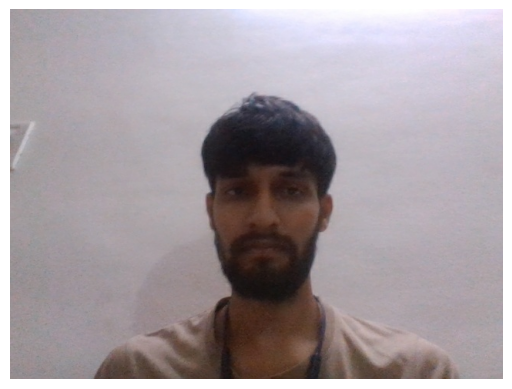

In [8]:
plt.imshow(images.as_numpy_iterator().next())
plt.axis('off')
plt.show()

In [9]:
images_generator = images.batch(4).as_numpy_iterator()

### Partition Unaugmented Data

##### Manually partioned into train, test, val

In [10]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_path = os.path.join('data', 'labels', filename)
        if(os.path.exists(existing_path)):
            new_file_path = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_path, new_file_path)

### Applying Image Augmentation

In [11]:
import albumentations as alb

In [12]:
augmentator = alb.Compose([alb.RandomCrop(width=450, height=450),
                              alb.HorizontalFlip(p=0.5),
                              alb.RandomBrightnessContrast(p=0.2),
                              alb.RandomGamma(p=0.2),
                              alb.RGBShift(p=0.2),
                              alb.VerticalFlip(p=0.5)],
                              bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [13]:
import cv2
img = cv2.imread(os.path.join('data', 'train', 'images', '7fb06ee0-e2b5-11ed-b034-c89402821e26.jpg'))
img.shape

(480, 640, 3)

In [14]:
with open(os.path.join('data', 'train', 'labels', '7fb06ee0-e2b5-11ed-b034-c89402821e26.json'), 'r') as f:
    label = json.load(f)

In [15]:
label['shapes']

[{'label': 'Face',
  'points': [[164.973544973545, 0.5820105820105941],
   [465.5026455026456, 342.38095238095235]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

In [16]:
cords=[0, 0, 0, 0]
cords[0] = label['shapes'][0]['points'][0][0]
cords[1] = label['shapes'][0]['points'][0][1]
cords[2] = label['shapes'][0]['points'][1][0]
cords[3] = label['shapes'][0]['points'][1][1]

In [17]:
cords

[164.973544973545, 0.5820105820105941, 465.5026455026456, 342.38095238095235]

In [18]:
cords = list(np.divide(cords, [640, 480, 640, 480]))
cords

[0.25777116402116407,
 0.0012125220458554043,
 0.7273478835978837,
 0.7132936507936507]

### Apply Augmentations

In [19]:
augmented = augmentator(image = img, bboxes=[cords], class_labels=['face'])
print(len(augmented))
print(augmented.keys())
print(augmented['image'].shape)
print(augmented['bboxes'])

3
dict_keys(['image', 'bboxes', 'class_labels'])
(450, 450, 3)
[(0.3399412110523223, 0.0, 1.0, 0.7119576719576719)]


(-0.5, 449.5, 449.5, -0.5)

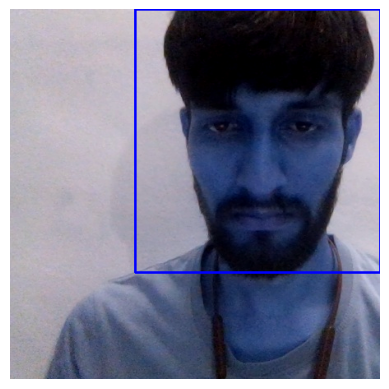

In [20]:
cv2.rectangle(augmented['image'],
              (int(augmented['bboxes'][0][0]*450), int(augmented['bboxes'][0][1]*450)),
              (int(augmented['bboxes'][0][2]*450), int(augmented['bboxes'][0][3]*450)),
              (0,0, 255),
              2
              )
plt.imshow(augmented['image'])
plt.axis('off')

##### Reason: Open cv read images in b g r and images read in matplotlib is r g b

In [21]:
augmented['bboxes'][0][0]*450

152.97354497354502

#### Build and Run Augmentation

##### Augmentation pipeline

In [22]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        cords=[0, 0, 0.000001, 0.000001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open (label_path, 'r') as f:
                label = json.load(f)
        
            cords[0] = label['shapes'][0]['points'][0][0]
            cords[1] = label['shapes'][0]['points'][0][1]
            cords[2] = label['shapes'][0]['points'][1][0]
            cords[3] = label['shapes'][0]['points'][1][1]
            cords = list(np.divide(cords, [640, 480, 640, 480]))
        
        try:
            for i in range(60):
                augmented = augmentator(image = img, bboxes=[cords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{i}.jpg'), augmented['image'])
                annotation={}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if(len(augmented['bboxes'])==0):
                        annotation['bbox']=[0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0
                    
                with open(os.path.join(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{i}.json')), 'w') as f:
                    json.dump(annotation, f)
                
        except Exception as e:
            print(e)

##### load augmented image in tensorflow

In [23]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*jpg', shuffle=False)
train_images = train_images.map(load_images)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x:x/255)

In [24]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*jpg', shuffle=False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x:x/255)

In [25]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*jpg', shuffle=False)
val_images = val_images.map(load_images)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x:x/255)

In [26]:
train_images.as_numpy_iterator().next().shape

(120, 120, 3)

### Prepare Labels

In [27]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [28]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [29]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [30]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [31]:
test_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.754  , 0.03067, 1.     , 1.     ], dtype=float16))

In [32]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2280, 2280, 600, 600, 480, 480)

In [33]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [34]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [35]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [36]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0]], dtype=uint8),
 array([[0.1511 , 0.139  , 0.718  , 0.823  ],
        [0.03348, 0.06046, 0.6753 , 0.919  ],
        [0.3933 , 0.08044, 1.     , 0.939  ],
        [0.2045 , 0.1449 , 0.7075 , 0.85   ],
        [0.424  , 0.1621 , 0.9204 , 0.882  ],
        [0.     , 0.1368 , 0.1191 , 0.8154 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

In [37]:
data_sample = train.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


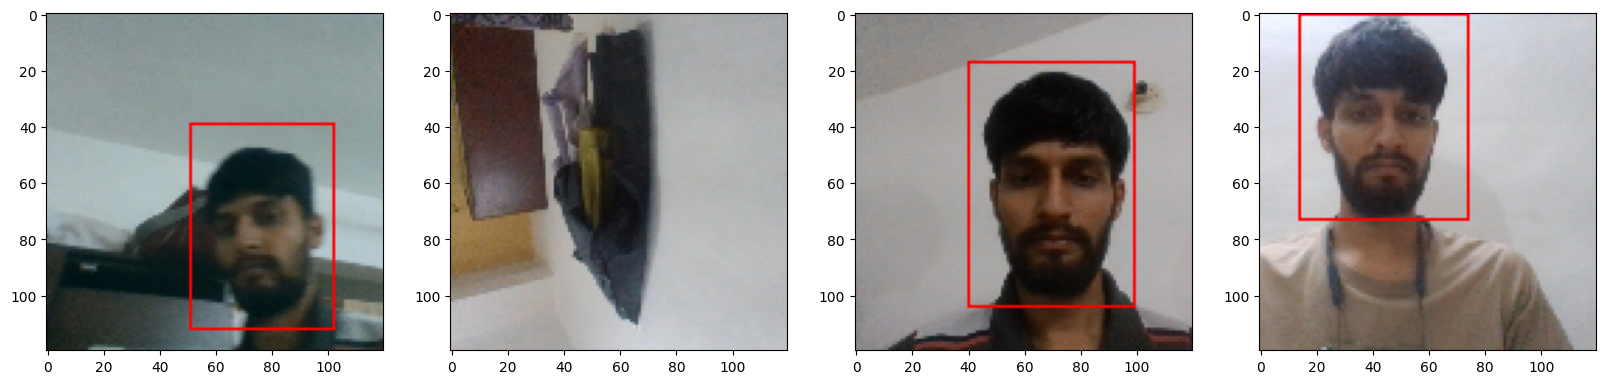

In [45]:
res = data_sample.next()
fig, ax = plt.subplots(ncols=4, figsize = (20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_cord = res[1][1][idx]
    cv2.rectangle(sample_image,
                  (int(sample_cord[0]*120), int(sample_cord[1]*120)),
                  (int(sample_cord[2]*120), int(sample_cord[3]*120)),
                  (255,0, 0), 1)
    ax[idx].imshow(sample_image)

### Building Neural Network

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Conv2D, Input

In [47]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [48]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    vgg = VGG16(include_top=False)(input_layer)
    
    #Classification 
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    #Regression
    f2 = GlobalMaxPooling2D()(vgg)
    reg1 = Dense(2048, activation='relu')(f2)
    reg2 = Dense(4, activation='sigmoid')(reg1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, reg2])
    return facetracker

In [49]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

### Saving them to train at kaggle / Google colab

In [50]:
tf.data.experimental.save(train, os.path.join('tensors_data', 'train'))

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [51]:
tf.data.experimental.save(test, os.path.join('tensors_data', 'test'))

In [52]:
tf.data.experimental.save(val, os.path.join('tensors_data', 'val'))

In [53]:
tf.keras.models.save_model(facetracker, filepath=os.path.join('tensors_data', 'untrained_model', 'untmodel.h5'))

### Define Loss and Decay Learning rate

In [54]:
batch_per_epoch = len(train)
lr_decay = (1/0.75-1)/batch_per_epoch

In [55]:
lr_decay

0.0011695906432748536

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=lr_decay)

### Localization Loss

In [57]:
def localization_loss(y_true, y_pred):
    delta_cord = tf.reduce_sum(tf.square(y_true[:, :2] - y_pred[:, :2]))
    
    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]
    
    h_pred = y_pred[:, 3] - y_pred[:, 1]
    w_pred = y_pred[:, 2] - y_pred[:, 0]
    
    delta_size = tf.reduce_sum(tf.square(h_true-h_pred)+tf.square(w_true-w_pred))
    return delta_cord + delta_size

In [58]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

#### Testing out loss metric

In [59]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [60]:
classes, cord = facetracker.predict(X)
classes, cord

1/1 [==============================] - 0s 406ms/step


(array([[0.43464974],
        [0.4699004 ],
        [0.41767785],
        [0.44801423],
        [0.45634127],
        [0.4087979 ],
        [0.4250124 ],
        [0.38746294]], dtype=float32),
 array([[0.573039  , 0.3621635 , 0.56345445, 0.46986264],
        [0.5568315 , 0.30750012, 0.45904762, 0.39389786],
        [0.6327676 , 0.4210055 , 0.5082433 , 0.44576016],
        [0.57862025, 0.38426036, 0.4410331 , 0.40965357],
        [0.5832939 , 0.35583296, 0.44178605, 0.41797784],
        [0.5694737 , 0.3514072 , 0.5278381 , 0.4540831 ],
        [0.5545574 , 0.37169194, 0.5176574 , 0.45415106],
        [0.588084  , 0.35689366, 0.45905653, 0.4767125 ]], dtype=float32))

In [61]:
localization_loss(y[1], cord).numpy()

6.7556615

In [62]:
classloss(y[1], classes).numpy()

0.63819647

In [139]:
class FaceModel(Model):
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        
    def compile(self, optimizer, classloss, regressloss, **kwargs ):
        super().compile(**kwargs)
        self.closs = classloss
        self.opt = optimizer
        self.lloss = regressloss
        
    def train_step(self, batch, **kwargs):
        X, y = batch
        
        with tf.GradientTape() as tape:
            classes, cords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_lloss = self.lloss(tf.cast(y[1], tf.float32), cords)
            total_loss = 0.5*batch_classloss + batch_lloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            
        optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss": total_loss, "class_loss": batch_classloss, "batch_lloss": batch_lloss}

    
    def test_step(self, batch, **kwargs):
        X, y = batch
        classes, cords = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_lloss = self.lloss(tf.cast(y[1], tf.float32), cords)
        total_loss = 0.5*batch_classloss + batch_lloss
        return {"total_loss": total_loss, "class_loss": batch_classloss, "batch_lloss": batch_lloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [140]:
facetrackerModel = FaceModel(facetracker)
facetrackerModel.compile(optimizer, classloss, localization_loss)

### Training

In [142]:
logdir = 'log'
tensorflow_callbacks = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [143]:
hist = facetrackerModel.fit(train, epochs=10, validation_data = val, callbacks=[tensorflow_callbacks])

Epoch 1/10
285/285 [==============================] - 400s 1s/step - total_loss: 0.0131 - class_loss: 3.7223e-04 - batch_lloss: 0.0129 - val_total_loss: 0.0363 - val_class_loss: 0.0011 - val_batch_lloss: 0.0357
Epoch 2/10
285/285 [==============================] - 379s 1s/step - total_loss: 0.0132 - class_loss: 3.0267e-04 - batch_lloss: 0.0130 - val_total_loss: 8.6275e-04 - val_class_loss: 4.5074e-04 - val_batch_lloss: 6.3738e-04
Epoch 3/10
285/285 [==============================] - 381s 1s/step - total_loss: 0.0100 - class_loss: 1.2774e-04 - batch_lloss: 0.0099 - val_total_loss: 0.0111 - val_class_loss: 0.0051 - val_batch_lloss: 0.0085
Epoch 4/10
285/285 [==============================] - 378s 1s/step - total_loss: 0.0086 - class_loss: 8.1987e-05 - batch_lloss: 0.0086 - val_total_loss: 0.0306 - val_class_loss: 3.6472e-05 - val_batch_lloss: 0.0306
Epoch 5/10
285/285 [==============================] - 378s 1s/step - total_loss: 0.0075 - class_loss: 6.7166e-05 - batch_lloss: 0.0075 - val

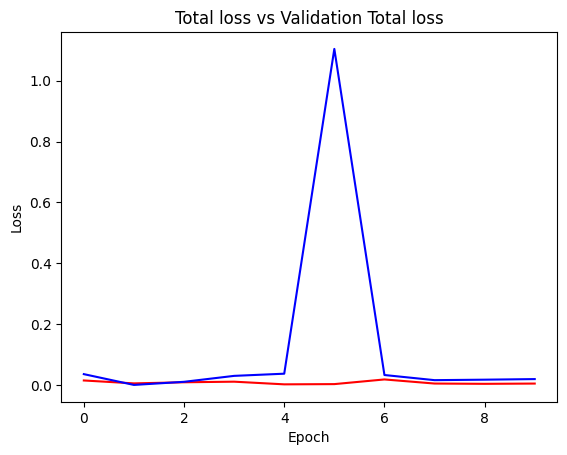

In [147]:
plt.plot(hist.history['total_loss'], c='red')
plt.plot(hist.history['val_total_loss'], c='blue')
plt.title("Total loss vs Validation Total loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


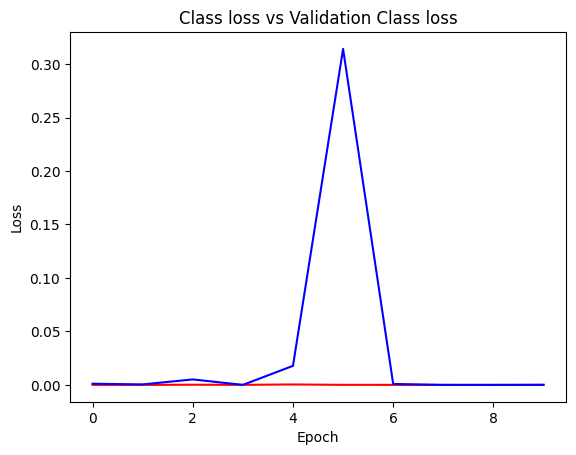

In [145]:
plt.plot(hist.history['class_loss'], c='red')
plt.plot(hist.history['val_class_loss'], c='blue')
plt.title("Class loss vs Validation Class loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

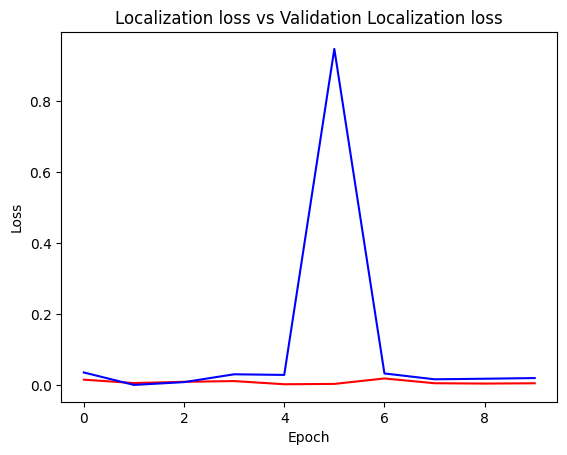

In [148]:
plt.plot(hist.history['batch_lloss'], c='red')
plt.plot(hist.history['val_batch_lloss'], c='blue')
plt.title("Localization loss vs Validation Localization loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Making Prediction

In [149]:
test_data = test.as_numpy_iterator()

1/1 [==============================] - 0s 246ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


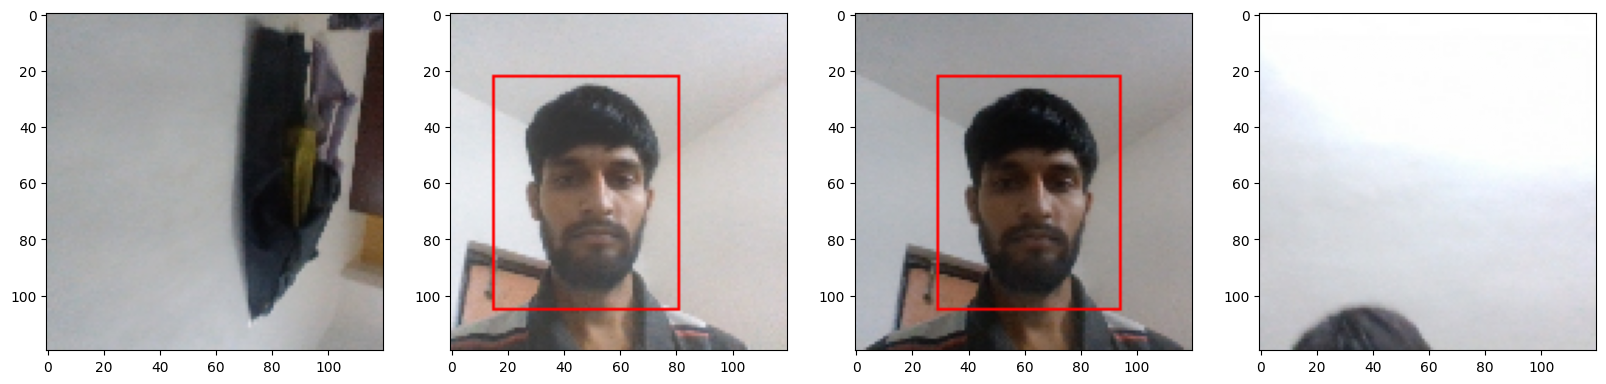

In [173]:
test_sample = test_data.next()
y_hat = facetrackerModel.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize = (20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_cord = y_hat[1][idx]
    
    if (y_hat[0][idx]) > 0.5:
        cv2.rectangle(sample_image,
                  (int(sample_cord[0]*120), int(sample_cord[1]*120)),
                  (int(sample_cord[2]*120), int(sample_cord[3]*120)),
                  (255,0, 0), 1)
    ax[idx].imshow(sample_image)
        

In [191]:
print(facetracker.get_weights()[0][0][0][0])

[ 0.42750663  0.11850806  0.03427919  0.35177526 -0.08907608  0.22566116
  0.06547262  0.03902048  0.12421285  0.03620704  0.09421919 -0.09409343
 -0.16335993  0.05433256 -0.08948627  0.15282619  0.01617951  0.0502003
  0.18799673 -0.0471383   0.3620029   0.23737033  0.16777615 -0.18079428
  0.04054314  0.09156113 -0.04226443 -0.19746642 -0.04582464 -0.1985293
 -0.23438805  0.11405111 -0.12668751  0.00753595 -0.24362051 -0.30704436
  0.06664374 -0.32716212  0.16970295  0.09694248 -0.11456438  0.32806852
 -0.06132744  0.18284781  0.01132271  0.1038454  -0.13071167 -0.36325815
  0.06525277  0.09193706  0.00092925  0.3778591   0.0485001  -0.2714234
  0.11174062 -0.11797035  0.04071385  0.3536141  -0.28649843 -0.21629441
 -0.28631085 -0.13805325 -0.05290054  0.00754384]


In [190]:
print(facetrackerModel.get_weights()[0][0][0][0])

[ 0.42750663  0.11850806  0.03427919  0.35177526 -0.08907608  0.22566116
  0.06547262  0.03902048  0.12421285  0.03620704  0.09421919 -0.09409343
 -0.16335993  0.05433256 -0.08948627  0.15282619  0.01617951  0.0502003
  0.18799673 -0.0471383   0.3620029   0.23737033  0.16777615 -0.18079428
  0.04054314  0.09156113 -0.04226443 -0.19746642 -0.04582464 -0.1985293
 -0.23438805  0.11405111 -0.12668751  0.00753595 -0.24362051 -0.30704436
  0.06664374 -0.32716212  0.16970295  0.09694248 -0.11456438  0.32806852
 -0.06132744  0.18284781  0.01132271  0.1038454  -0.13071167 -0.36325815
  0.06525277  0.09193706  0.00092925  0.3778591   0.0485001  -0.2714234
  0.11174062 -0.11797035  0.04071385  0.3536141  -0.28649843 -0.21629441
 -0.28631085 -0.13805325 -0.05290054  0.00754384]


In [192]:
tf.keras.models.save_model(facetracker, filepath=os.path.join('trained_model', 'version1', 'model.h5'))